In [6]:
import sys
import os
import shutil
import datetime
import re
import pandas as pd
from collections import Counter
#sys.path.append(os.path.abspath("/home/jose/Dropbox/Doktorarbeit/"))
#from reading_robot import load_data, tei2text, text2features, classify, process_labels, describe_data,feature_analysis, cull_data, st_tests, metadata2numbers, cluster, call_stylo, prepare_subcorpus
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
%matplotlib inline
from shutil import copyfile
import numpy as np
import glob

# Read Data

In [7]:
df = pd.read_csv("./../results/202210_all_filtered.tsv", sep="\t", index_col=0)

In [8]:
df["distances"].value_counts()

dist.eder        1094
dist.delta       1094
dist.wurzburg    1094
dist.minmax      1094
Name: distances, dtype: int64

In [9]:
df["corpus"].unique()

array(['novelas-hispanoamericanas', 'disco', 'prosa-SdO',
       'Poesia_SiglodeOro', 'cuentos-espanoles', 'teatro-sgo',
       'novelas-espanolas'], dtype=object)

In [10]:
df["corpus"].replace(
    {
        'prosa-SdO': "16-17-prosa",
        'Poesia_SiglodeOro': "16-17-poesia",
        'teatro-sgo': "16-17-teatro",
        "disco" : "19-20-poesia",
        "novelas-espanolas" : "19-20-nov-esp",
        "novelas-hispanoamericanas" : "19-20-nov-hisp",
        "cuentos-espanoles" : "19-20-cuent-esp",
        }, inplace=True)

In [11]:
df

,corpus,version,mfw,features,ngrams,distances,media
0,19-20-nov-hisp,combination,100,w,4,dist.minmax,56.607143
1,19-20-poesia,combination,100,c,1,dist.minmax,35.441089
2,19-20-poesia,combination,100,c,3,dist.eder,36.600046
3,19-20-poesia,combination,100,c,4,dist.eder,36.613470
4,19-20-poesia,combination,100,c,4,dist.minmax,37.338606
...,...,...,...,...,...,...,...
6265,19-20-poesia,fusion,5000,w,2,dist.delta,42.506842
6267,19-20-poesia,only-tokens,5000,w,1,dist.wurzburg,75.415982
6268,16-17-poesia,only-tokens,5000,w,1,dist.eder,87.285741
6269,16-17-poesia,only-tokens,5000,w,1,dist.wurzburg,87.234585


In [12]:
df["distances"].replace(
    {
        'dist.wurzburg': "dist.delta.cosine",
        'dist.eder': "dist.delta.eder",
        'dist.delta': "dist.delta.burrows",
        }, inplace=True)

In [13]:
df["distances"].unique()

array(['dist.minmax', 'dist.delta.eder', 'dist.delta.cosine',
       'dist.delta.burrows'], dtype=object)

In [14]:
df["features"].replace(
    {
        'c': "character",
        'w': "word",
        }, inplace=True)

In [15]:
df.sort_values(by=["corpus", "mfw"], inplace=True)

In [16]:

color = "#669999"
cmap_20 = "tab20_r"
cmap_8 = "Dark2"

def plot_boxplots_by(df, column_to_plot, column_by, figsize = (20,5), color = color, xlabel = "", ylabel = "", title = "", outdir = "./../visualizations/", figure_name = "boxplot_xlabel_by_ylabel", rot = 0):
    """
        plot_boxplots_by(df.sample(10000, random_state=2021), column_to_plot = "entry_first_date_year", column_by = "year_publication", xlabel= "year of publication", ylabel= "year of first record in K10plus",
        title = "Boxplot of year of first entry by year of publication",
        figure_name = "boxplot_year_publication_year_entry_catalog")
    """

    boxprops = dict(linestyle='-', linewidth=2, )
    medianprops = dict(linestyle='-', linewidth=2)
    whiskerprops = dict(linestyle='-',linewidth=2)    

    ax = df.boxplot(column_to_plot, by = column_by, figsize = figsize, color=color, boxprops=boxprops,
                medianprops=medianprops, whiskerprops = whiskerprops, rot = rot)
    ax.set_title(title)
    ax.set_axisbelow(True)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig = ax.get_figure()
    fig.suptitle("")
    fig.savefig(outdir + figure_name + ".png", facecolor='white', transparent=False)


In [17]:
outdir = "./../visualisations/"

In [18]:
df

,corpus,version,mfw,features,ngrams,distances,media
22,16-17-poesia,only-tokens,100,word,3,dist.delta.cosine,22.938103
23,16-17-poesia,only-tokens,100,word,3,dist.minmax,21.186811
24,16-17-poesia,only-tokens,100,word,3,dist.delta.eder,19.110037
25,16-17-poesia,only-tokens,100,word,3,dist.delta.burrows,17.199598
26,16-17-poesia,only-tokens,100,word,4,dist.delta.cosine,12.700059
...,...,...,...,...,...,...,...
6238,19-20-poesia,fusion,5000,word,4,dist.delta.burrows,17.411948
6247,19-20-poesia,combination,5000,character,3,dist.delta.burrows,44.417500
6258,19-20-poesia,only-tokens,5000,character,4,dist.delta.cosine,75.390334
6265,19-20-poesia,fusion,5000,word,2,dist.delta.burrows,42.506842


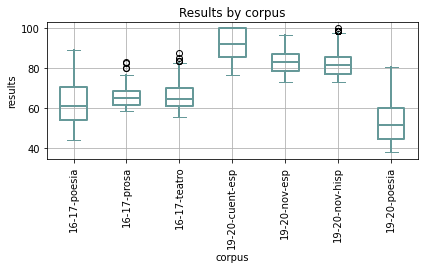

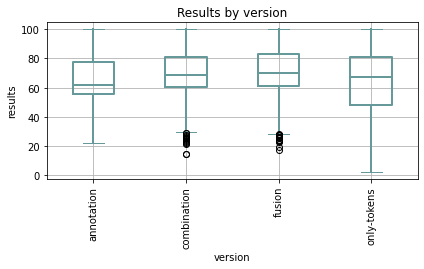

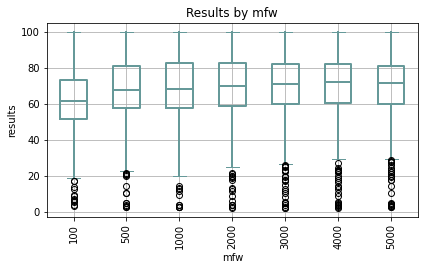

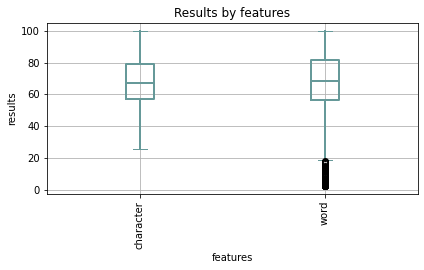

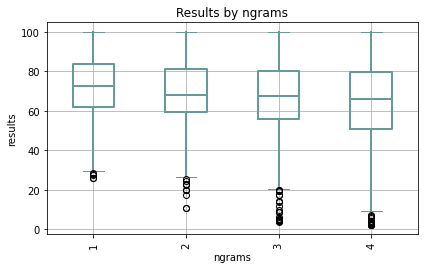

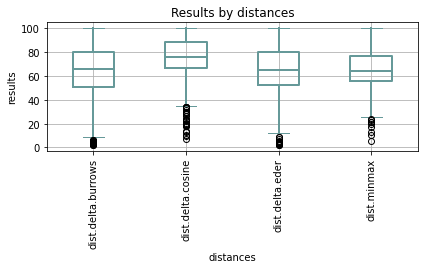

In [19]:
for column in ['corpus', 'version', 'mfw', 'features', 'ngrams', 'distances']:
    

    plot_boxplots_by(df.sort_values(by="media",ascending=False).groupby(["corpus",column]).head(500), "media",
        column, outdir = outdir, figure_name = "several corpora", figsize=(6,4), rot=90,
        title ="Results by " + column, xlabel = column, ylabel = "results",)


    plt.tight_layout()
    plt.savefig(outdir + "boxplot_" + column+ '.png', dpi=300, format="png", facecolor='white', transparent=False)
    plt.show()

In [20]:
def facetGrid(data_df, data_plot, col, row, facet, outdir, dataset, aspect=1.5, type_=plt.scatter, alpha = 0.5, ylim = 0, rotation = 0):
    if type_ == plt.scatter:
            g = sns.FacetGrid(data_df, col = col, row = row, aspect = aspect, margin_titles=True, legend_out = True, ylim = ylim)
            #g = (g.map(type_, facet, data_plot, alpha = alpha ) .add_legend())
            plt.subplots_adjust(top = 0.95, right = 0.93)
    elif type_ == plt.boxplot or type_ == sns.boxplot:
            g = sns.FacetGrid(data_df, col = col, row = row, aspect = aspect, margin_titles=True)
            g.map(type_, facet, data_plot)
            #plt.subplots_adjust(top = 0.95, right = 0.98)

    #[plt.setp(ax.get_xticklabels(), rotation = rotation) for ax in g.axes.flat]

    #g.fig.suptitle("Facet Grid with " + col + ", "+ row + " and " + facet + " in "+ dataset)

    plt.savefig(outdir + dataset + "_scatt_" + col + "_" + row + "_" + facet + '.png', dpi=300, format="png", facecolor='white', transparent=False)
    plt.show()



c:\Users\calvotello\Anaconda3\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


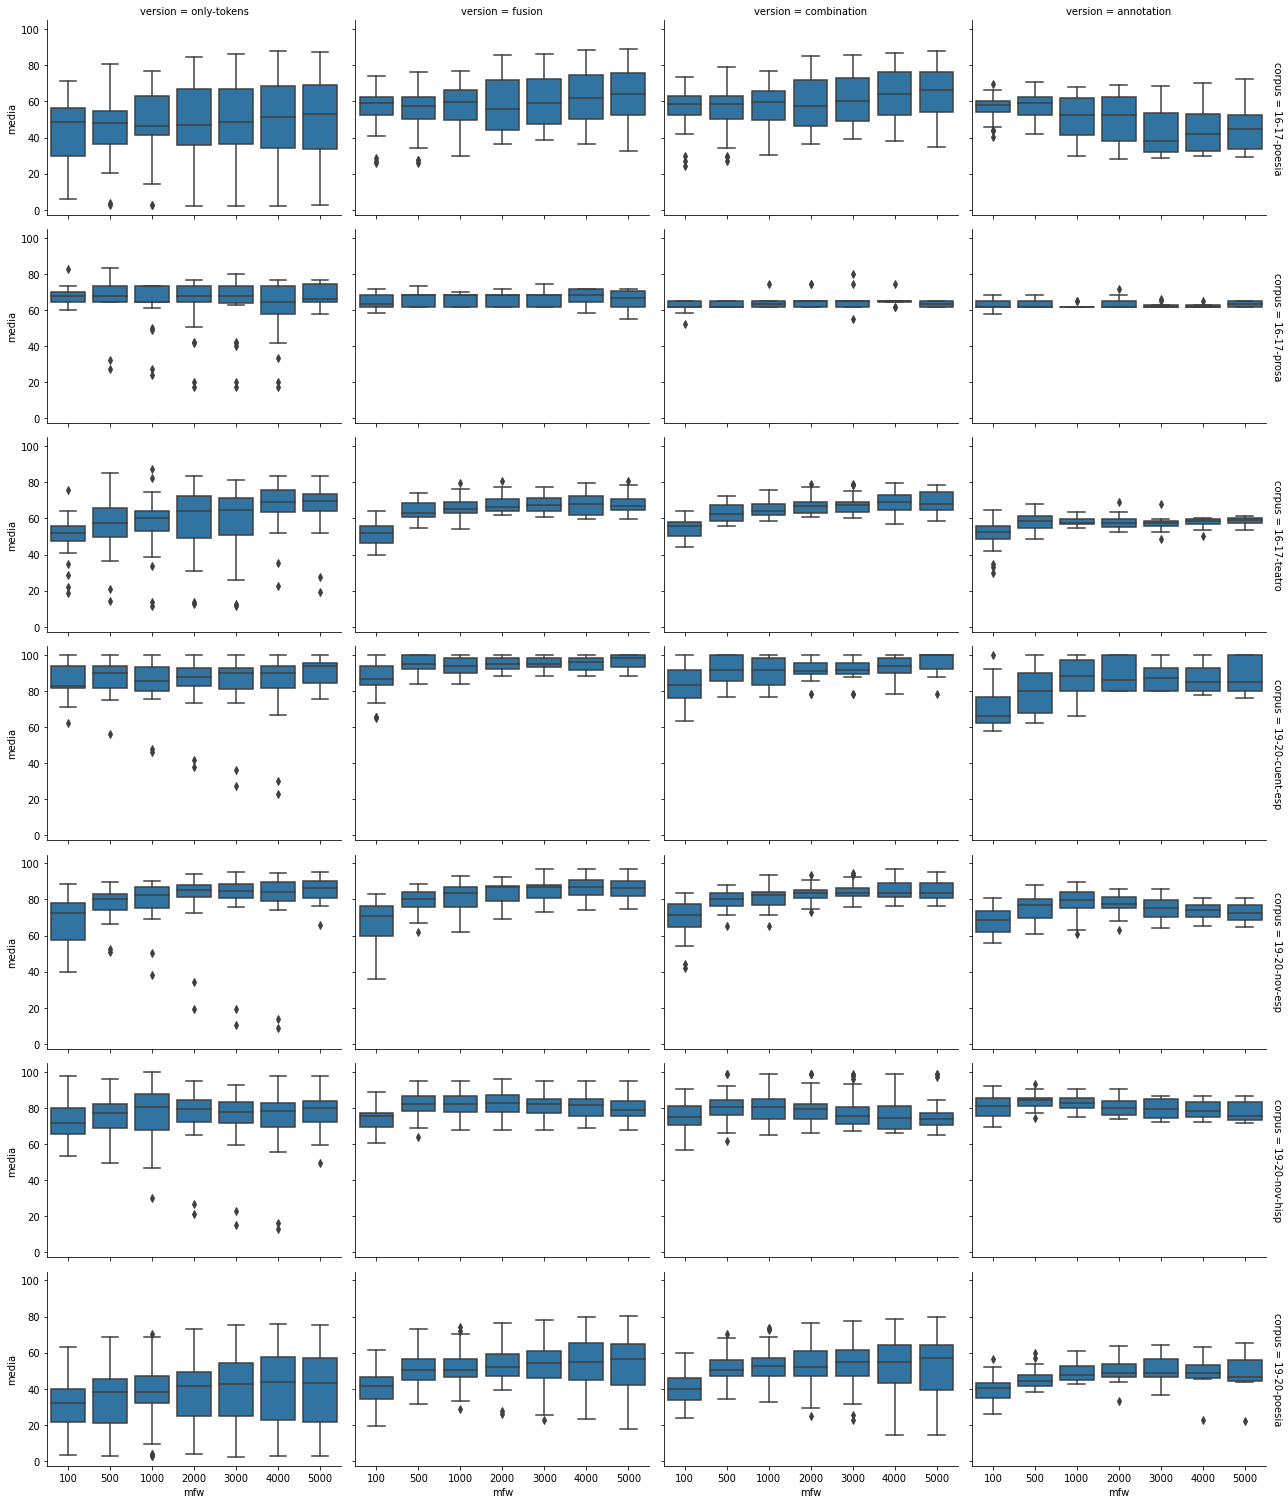

In [21]:
import seaborn as sns
facetGrid(df.groupby(["corpus","version","mfw"]).head(500),
                        "media", "version","corpus", "mfw",
                        outdir, "Several corpora", ylim = 0, type_ = sns.boxplot
            )

c:\Users\calvotello\Anaconda3\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


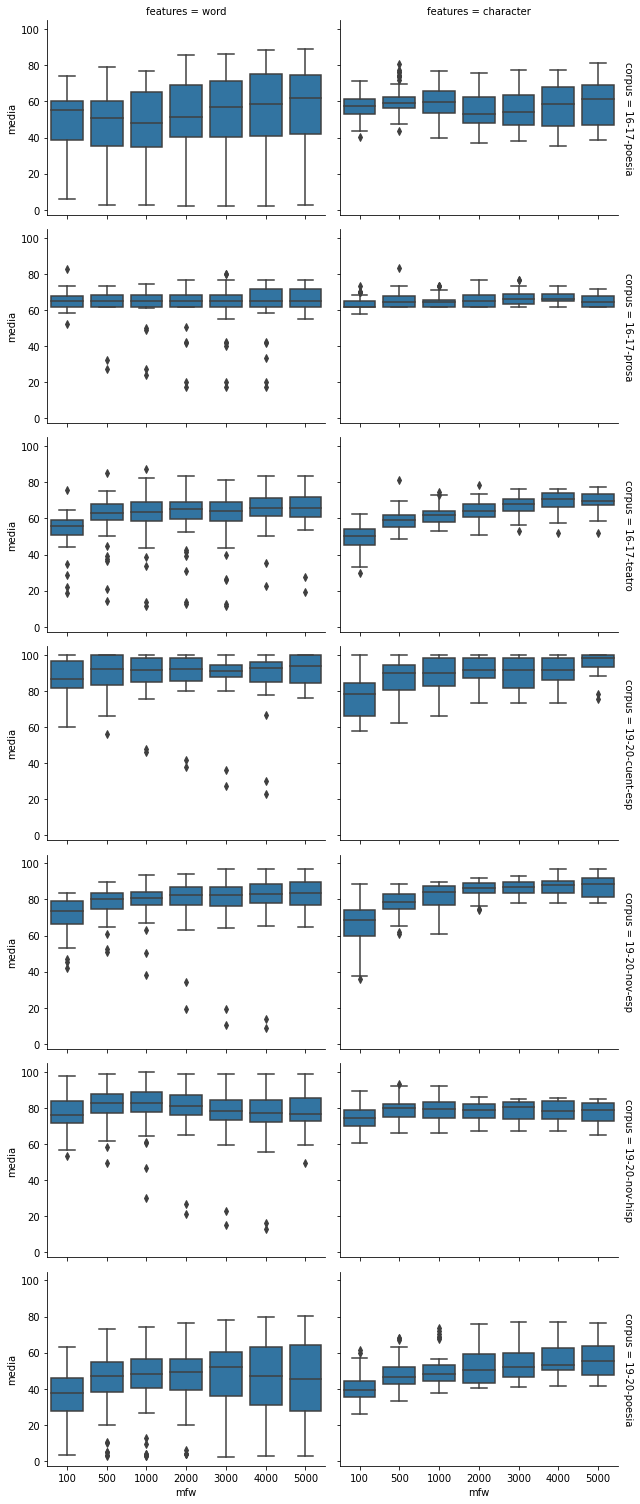

In [22]:
facetGrid(df.groupby(["corpus","features","mfw"]).head(500),
                        "media", "features","corpus", "mfw",
                        outdir, "Several corpora", ylim = 0, type_ = sns.boxplot
            )

c:\Users\calvotello\Anaconda3\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


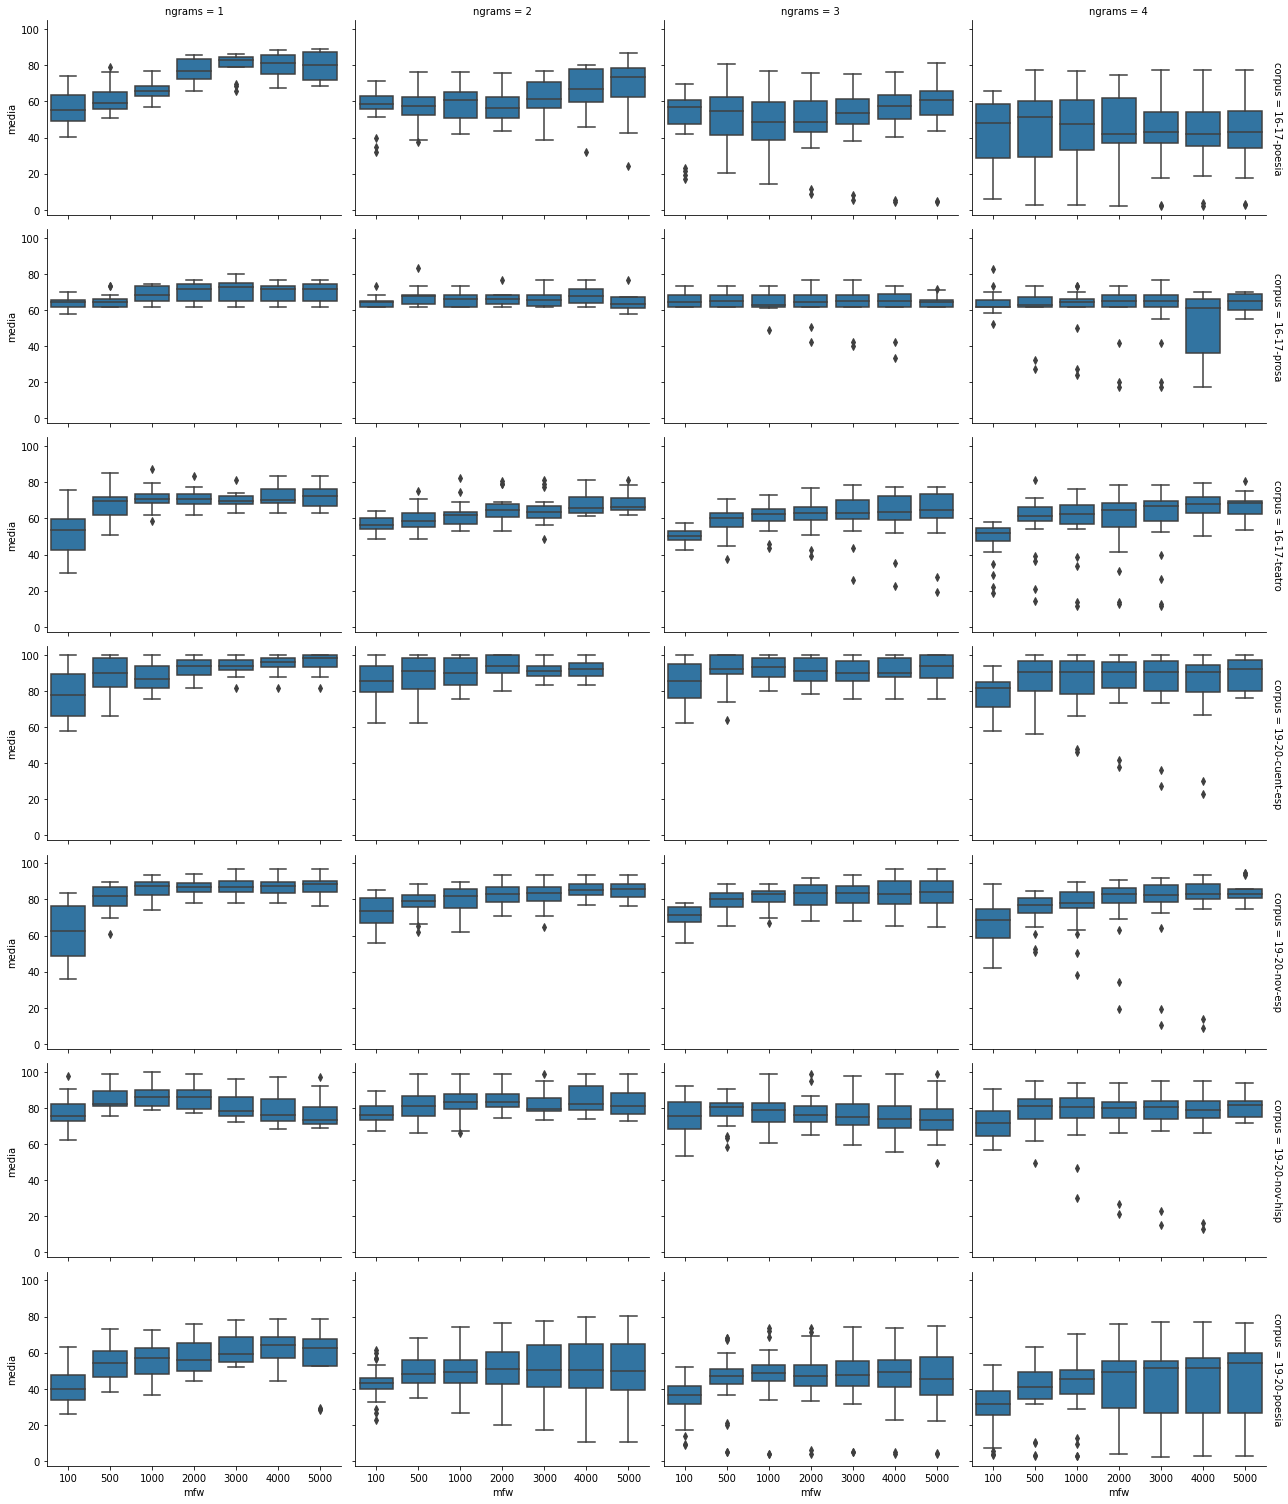

In [23]:
facetGrid(df.groupby(["corpus","ngrams","mfw"]).head(500),
                        "media", "ngrams","corpus", "mfw",
                        outdir, "Several corpora", ylim = 0, type_ = sns.boxplot
            )

c:\Users\calvotello\Anaconda3\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


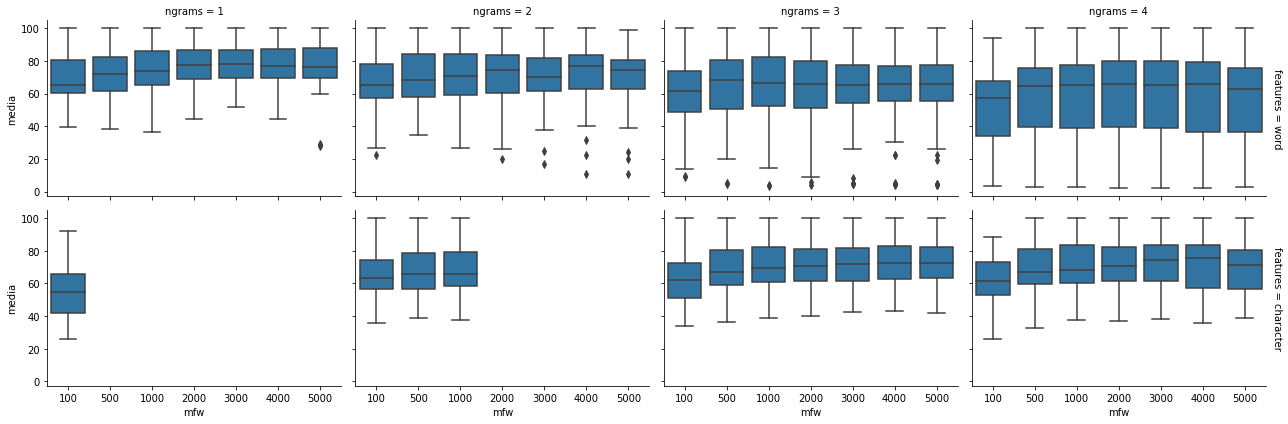

In [24]:
facetGrid(df.groupby(["corpus","ngrams","mfw","features"]).head(500),
                        "media", "ngrams","features", "mfw",
                        outdir, "Several corpora", ylim = 0, type_ = sns.boxplot
            )

c:\Users\calvotello\Anaconda3\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


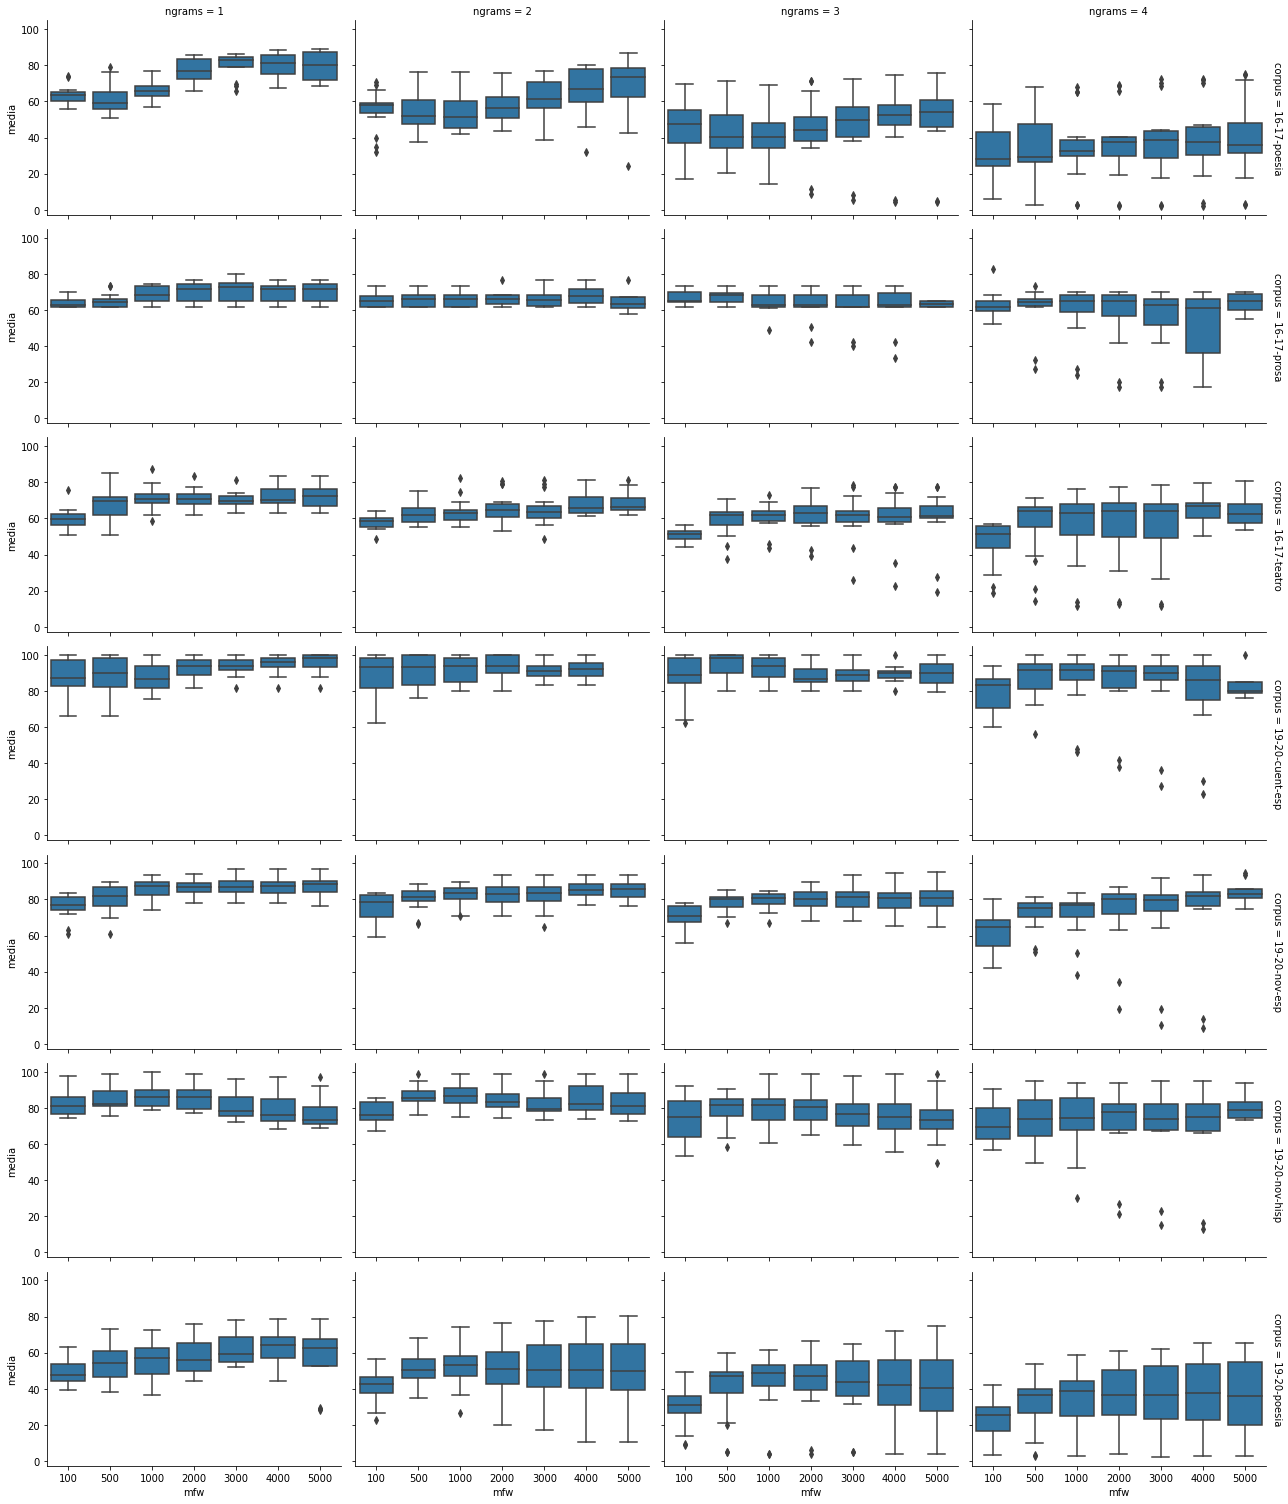

In [25]:
facetGrid(df.loc[df["features"] == "word"].groupby(["corpus","ngrams","mfw"]).head(500),
                        "media", "ngrams","corpus", "mfw",
                        outdir, "words ngrams corpora mfws", ylim = 0, type_ = sns.boxplot
            )

c:\Users\calvotello\Anaconda3\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


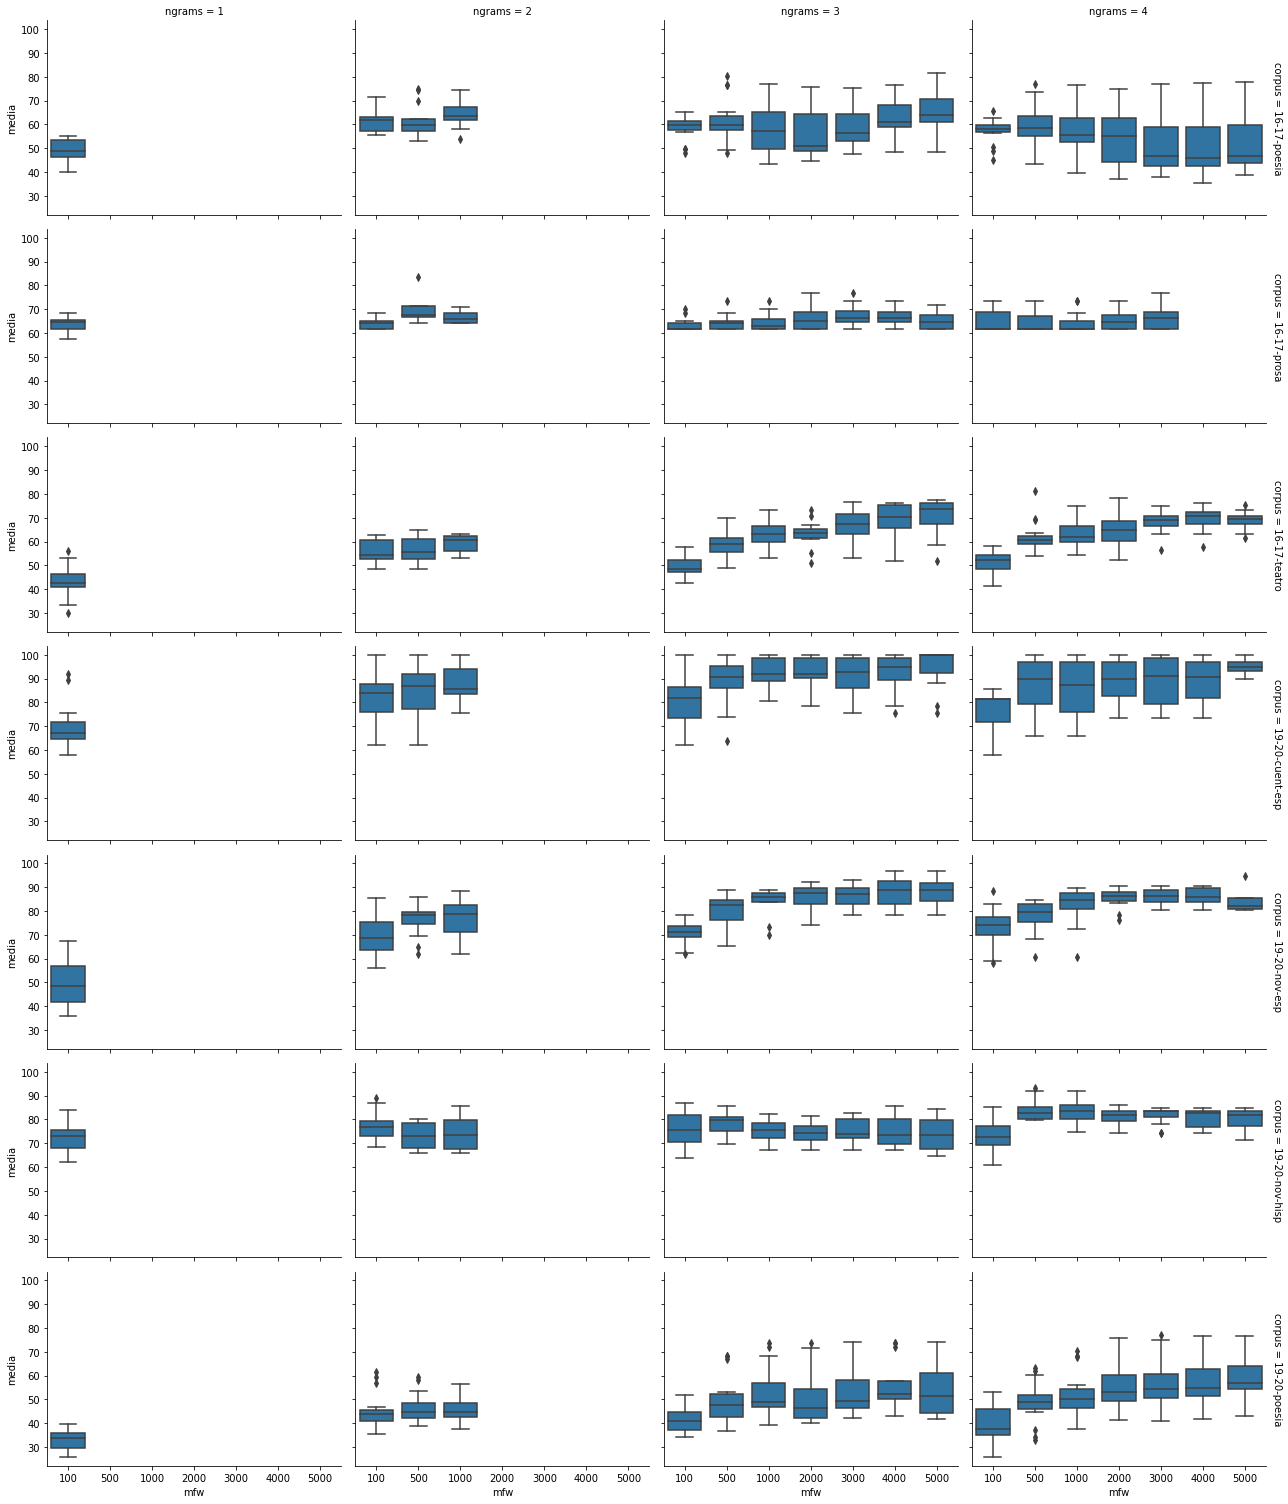

In [26]:
facetGrid(df.loc[df["features"] == "character"].groupby(["corpus","ngrams","mfw"]).head(500),
                        "media", "ngrams","corpus", "mfw",
                        outdir, "character ngrams corpora mfws", ylim = 0, type_ = sns.boxplot
            )

c:\Users\calvotello\Anaconda3\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


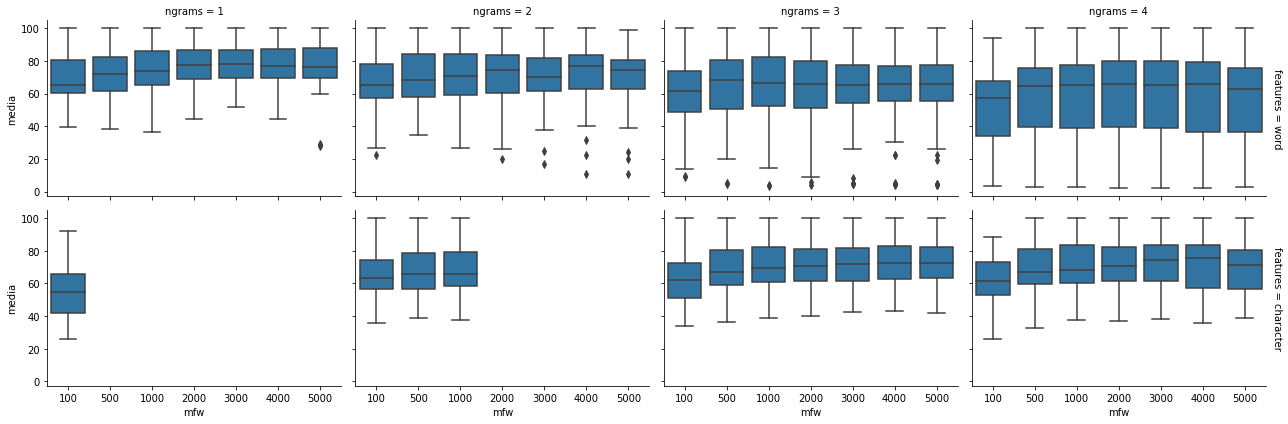

In [27]:
facetGrid(df,
            "media", "ngrams","features", "mfw",
            outdir, "features ngrams", ylim = 0, type_ = sns.boxplot
            )

# Tests

In [28]:
df

,corpus,version,mfw,features,ngrams,distances,media
22,16-17-poesia,only-tokens,100,word,3,dist.delta.cosine,22.938103
23,16-17-poesia,only-tokens,100,word,3,dist.minmax,21.186811
24,16-17-poesia,only-tokens,100,word,3,dist.delta.eder,19.110037
25,16-17-poesia,only-tokens,100,word,3,dist.delta.burrows,17.199598
26,16-17-poesia,only-tokens,100,word,4,dist.delta.cosine,12.700059
...,...,...,...,...,...,...,...
6238,19-20-poesia,fusion,5000,word,4,dist.delta.burrows,17.411948
6247,19-20-poesia,combination,5000,character,3,dist.delta.burrows,44.417500
6258,19-20-poesia,only-tokens,5000,character,4,dist.delta.cosine,75.390334
6265,19-20-poesia,fusion,5000,word,2,dist.delta.burrows,42.506842


In [29]:
from  scipy import stats

In [30]:
def add_significance(df, class_pvalue = "test_result_pvalue"):
    df["significance"] = ""
    df.loc[df[class_pvalue] < 0.05,"significance"] = "*"
    df.loc[df[class_pvalue] < 0.01,"significance"] = "**"
    df.loc[df[class_pvalue] < 0.001,"significance"] = "***"
    return df


def test_differences_columns(df, column_class, column_value, equal_var=False):
    results_lt = []
    seen_values = []
    for value1 in sorted(list(set(df[column_class]))):
        for value2 in sorted(list(set(df[column_class]))):
            if value2 not in seen_values and value1 != value2:

                statistic, pvalue = stats.ttest_ind(
                            df.loc[df[column_class]==value1].sort_values(by="media",ascending=False).groupby(["corpus",column_class]).head(500)[column_value],
                            df.loc[df[column_class]==value2].sort_values(by="media",ascending=False).groupby(["corpus",column_class]).head(500)[column_value],
                    equal_var=equal_var
                            )
                difference = df.loc[df[column_class]==value1][column_value].mean()- df.loc[df[column_class]==value2][column_value].mean()
                seen_values.append(value1)
                results_lt.append([value1,value2,pvalue, difference])
    results_df = pd.DataFrame(results_lt, columns=["value1","value2","pvalue", "mean_difference"])
    results_df = add_significance(results_df, class_pvalue = "pvalue")
    
    return results_df

In [39]:
df

,corpus,version,mfw,features,ngrams,distances,media
22,16-17-poesia,only-tokens,100,word,3,dist.delta.cosine,22.938103
23,16-17-poesia,only-tokens,100,word,3,dist.minmax,21.186811
24,16-17-poesia,only-tokens,100,word,3,dist.delta.eder,19.110037
25,16-17-poesia,only-tokens,100,word,3,dist.delta.burrows,17.199598
26,16-17-poesia,only-tokens,100,word,4,dist.delta.cosine,12.700059
...,...,...,...,...,...,...,...
6238,19-20-poesia,fusion,5000,word,4,dist.delta.burrows,17.411948
6247,19-20-poesia,combination,5000,character,3,dist.delta.burrows,44.417500
6258,19-20-poesia,only-tokens,5000,character,4,dist.delta.cosine,75.390334
6265,19-20-poesia,fusion,5000,word,2,dist.delta.burrows,42.506842


In [31]:
df.columns.tolist()

['corpus', 'version', 'mfw', 'features', 'ngrams', 'distances', 'media']

In [32]:
test_differences_columns(df, "features", "media")

,value1,value2,pvalue,mean_difference,significance
0,character,word,0.015542,1.34387,*


In [33]:
test_differences_columns(df, "ngrams", "media").round(3)

,value1,value2,pvalue,mean_difference,significance
0,1,2,0.001,2.566,**
1,1,3,0.000,5.003,***
2,1,4,0.000,8.540,***
3,2,3,0.001,2.437,***
4,2,4,0.000,5.974,***
5,3,4,0.000,3.537,***


In [34]:
test_differences_columns(df, "corpus", "media")

,value1,value2,pvalue,mean_difference,significance
0,16-17-poesia,16-17-prosa,3.738070e-11,-10.017233,***
1,16-17-poesia,16-17-teatro,2.622782e-09,-6.662857,***
2,16-17-poesia,19-20-cuent-esp,6.422160e-256,-33.342659,***
3,16-17-poesia,19-20-nov-esp,2.089135e-175,-23.998345,***
4,16-17-poesia,19-20-nov-hisp,1.121216e-166,-23.856206,***
5,16-17-poesia,19-20-poesia,2.487973e-37,8.310328,***
6,16-17-prosa,16-17-teatro,7.560336e-01,3.354376,
7,16-17-prosa,19-20-cuent-esp,0.000000e+00,-23.325427,***
8,16-17-prosa,19-20-nov-esp,5.299278e-292,-13.981112,***
9,16-17-prosa,19-20-nov-hisp,1.191259e-242,-13.838973,***


In [35]:
test_differences_columns(df, "mfw", "media").round(3)

,value1,value2,pvalue,mean_difference,significance
0,100,500,0.000,-5.960,***
1,100,1000,0.000,-6.514,***
2,100,2000,0.000,-6.764,***
3,100,3000,0.000,-6.807,***
4,100,4000,0.000,-7.112,***
5,100,5000,0.000,-6.602,***
6,500,1000,0.571,-0.554,
7,500,2000,0.440,-0.804,
8,500,3000,0.428,-0.847,
9,500,4000,0.304,-1.152,


In [36]:
test_differences_columns(df, "distances", "media").round(3)

,value1,value2,pvalue,mean_difference,significance
0,dist.delta.burrows,dist.delta.cosine,0.000,-12.168,***
1,dist.delta.burrows,dist.delta.eder,0.624,-0.430,
2,dist.delta.burrows,dist.minmax,0.215,-0.972,
3,dist.delta.cosine,dist.delta.eder,0.000,11.738,***
4,dist.delta.cosine,dist.minmax,0.000,11.196,***
5,dist.delta.eder,dist.minmax,0.475,-0.542,


In [37]:
test_differences_columns(df, "version", "media").round(3)

,value1,value2,pvalue,mean_difference,significance
0,annotation,combination,0.000,-4.442,***
1,annotation,fusion,0.000,-5.116,***
2,annotation,only-tokens,0.023,2.018,*
3,combination,fusion,0.324,-0.674,
4,combination,only-tokens,0.000,6.461,***
5,fusion,only-tokens,0.000,7.134,***


In [38]:
#stats.ttest_ind(, equal_var=False)
